In [1]:
from report import *
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

total: 176474
residents: 160748
vacant: 15726
edges: 132489


In [2]:
"""
load model path/report table
"""
import os
path='model/'
files = [f[:-4] for f in os.listdir(path) if f.endswith('.mps')]
files.sort()

model_house_df = pd.read_csv('modelsTable',index_col=0)
model_house_df = pd.DataFrame(np.array(model_house_df),
                              columns=['model','iter','Cost','Num_of_houses','ObjVal','Time','budg'] + 
                              list(gdf.ID) + ["power","distance"])

In [5]:
def read_geo_file(file_name = 'OriginalDataBaseFile/RealPropertiesExtraClean.csv'):
    """ 
    read file from csv and return geodataframe
    """
    df = pd.read_csv(file_name) 
    df.rename(columns={"Parcel":"geometry"},inplace=True)
    df.geometry = df.geometry.apply(lambda var: MultiPolygon([wkt.loads(var)])) # string to multipolygon

    gdf = gpd.GeoDataFrame(df)
    gdf["Block"] = gdf.BlockLot.apply(lambda num: num[:4])
    gdf.crs = {'init' :'epsg:4326'}
    
    gdf['x'] = gdf.geometry.centroid.x # Longitude
    gdf['xradians'] = gdf.x.apply(radians) # x coords to radians
    gdf['y'] = gdf.geometry.centroid.y # Latitude
    gdf['yradians'] = gdf.y.apply(radians) # y coords to radians
    gdf['yx'] = zip(gdf.y,gdf.x) # (lat, lon)
    
    # for optimization computation
    gdf['xyradians'] = zip(gdf.xradians,gdf.yradians)
    gdf['xyrID'] = zip(gdf.xyradians,gdf.ID)
    
    return gdf
totalgdf = read_geo_file()
check = set(gdf.ID)
background = totalgdf[totalgdf.ID.apply(lambda var: var not in check)]

In [6]:
def real_dis_affect(col,col2,power = 1, upper = 500):
    lon1, lat1 = col
    lon2, lat2 = col2
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    dis = R * c*1000 
    #return dis if dis < upper else 0

    return 1.0/(dis**power) if dis < upper else 0

def colorembed(var, max_):
    if var > max_*2.0/3:
        return 3
    if var > max_*1.0/3.0:
        return 2
    if var > 0:
        return 1
    return 0

In [8]:
"""
load improvment dictionary if exist
"""
#improvementdict = {}

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
def Area_plot(file_ ,iter_, budg , ax= None,radius = None, power = None, coltype = 1):
    #print file_,iter_
    demolished = model_house_df[(model_house_df.model == file_) & (model_house_df.iter == iter_) & 
                                (model_house_df.budg == budg)].iloc[0,7:]

    tempgdf = gdf.copy()
    tempgdf["demolished"] = tempgdf.ID.apply(lambda var: demolished[var])

    if not radius:
        radius = int(file_.split("-")[1][1:])
        power = int(file_.split("-")[2][1:])
    
    
    tempogdf = ogdf.copy()
    tempogdf["improve"] = np.zeros(len(tempogdf))
    tempogdf.set_index('ID',inplace = True)
    
    # try get the object value again.......QQ
    count = 0
    for id_ in tempgdf[tempgdf.demolished == 1].ID:
        
        index = tempogdf[((tempogdf.xradians <= vgdf[vgdf.ID == id_].xradians.iloc[0] + 0.00012) & 
        (tempogdf.xradians >= vgdf[vgdf.ID == id_].xradians.iloc[0] - 0.00012) &
        (tempogdf.yradians <= vgdf[vgdf.ID == id_].yradians.iloc[0] + 0.0001) & 
        (tempogdf.yradians >= vgdf[vgdf.ID == id_].yradians.iloc[0] - 0.0001) )].index

        
        curpoint = vgdf[vgdf.ID == id_].xyradians.iloc[0]
            
        curval = list(tempogdf.loc[index,"xyrID"].apply(
            lambda var: real_dis_affect(var[0],curpoint,
                                        power = power,upper = radius)))
        tempogdf.loc[index,"improve"] += curval
        
        if sum(curval) == 0:
            print "no houses around!"
        
        count += 1
        
    # color map:
    ##   hot_r, cubehelix, gnuplot2, inferno
    vmin_ = 0
    colormap = 'inferno'
    vacantcolor = "aliceblue"
    vmax_ = tempogdf.improve.max() * 1.15
    
    if file_ == "base":
        vmax_ = improvementdict[(budg,radius,power)][0]
        improvementdict[(budg,radius,-1)] = [tempogdf.improve.max(),tempogdf.improve.sum(),
                                                len(tempogdf.improve.nonzero()[0])]
    else:
        improvementdict[(budg,radius,power)] = [vmax_,tempogdf.improve.sum(),
                                                len(tempogdf.improve.nonzero()[0])]
        
    selfax = False
    if ax == None:
        fig = plt.figure(figsize=(16,16), dpi=150)
        ax = fig.add_subplot(111)
        ax2 = fig.add_axes([0.07,0.06,0.25,0.29])
        ax3 = fig.add_axes([0.35,0.06,0.24,0.24])
        selfax = True
    ax.set_xlim(-76.7,-76.55)
    ax.set_ylim(39.270,39.36)
    background.plot(ax = ax, color = "gainsboro")
    tempgdf[(tempgdf.IsVacant == 1) ].plot(ax = ax,color = "pink" )
    
    #print "m:{}_i:{}_b:{} ---totoal impact improvement--- {}".format(file_,iter_,budg,tempogdf.improve.sum())
    #print "m:{}_i:{}_b:{} ---totoal houses cover--- {}".format(file_,iter_,budg,
                                                                #len(tempogdf.improve.nonzero()[0]))
    if coltype == 1:
        tempogdf[(tempogdf.x < -76.50) & 
                 (tempogdf.x > -76.73) & 
                 (tempogdf.y < 39.4) & 
                 (tempogdf.y > 39.25) ].plot(ax = ax, column = "improve",cmap = colormap ,vmin = vmin_,vmax = vmax_ )
    elif coltype == 2:
        tempogdf.improve = tempogdf.improve.apply(lambda var: colorembed(var,vmax_))
        colortemp = ["black","seagreen","deeppink","darkorange"]
        for i in xrange(4):
            if tempogdf[(tempogdf.x < -76.50) & 
                     (tempogdf.x > -76.73) & 
                     (tempogdf.y < 39.4) & 
                     (tempogdf.y > 39.25) & (tempogdf.improve == i)].shape[0] != 0:
                tempogdf[(tempogdf.x < -76.50) & 
                         (tempogdf.x > -76.73) & 
                         (tempogdf.y < 39.4) & 
                         (tempogdf.y > 39.25) & (tempogdf.improve == i)].plot(ax=ax, color = colortemp[i])

    
    # add colorbar
    if selfax == True:
        cax = fig.add_axes([1, 0.02 , 0.01, 0.97])
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin_, vmax=vmax_))
        # fake up the array of the scalar mappable. Urgh...
        sm._A = []
        cb = fig.colorbar(sm, cax= cax, boundaries=np.linspace(0,tempogdf.improve.max(),101))
        fig.tight_layout()
    #else:
    #    sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=vmin_, vmax=vmax_))
        # fake up the array of the scalar mappable. Urgh...
    #    sm._A = []
        cb = plt.colorbar(sm, ax= ax, boundaries=np.linspace(0,tempogdf.improve.max(),101))
        #fig.tight_layout()
        
    
    
    # save figure
    #if not radius:
    #    fig.savefig('newimages/{}_iter{}_budg{}_area.pdf'.format(file_,iter_,budg),format='pdf', dpi=1000,bbox_inches='tight')
    #else:
    #    fig.savefig('newimages/{}_d{}_p{}_iter{}_budg{}_area.pdf'.format(file_,radius,power,iter_,budg),format='pdf', dpi=1000,bbox_inches='tight')
    #fig.savefig('newimages/{}_iter{}_budg{}_area.pdf'.format(file_,iter_,budg),format='pdf', dpi=1000,bbox_inches='tight')
    #return tempogdf

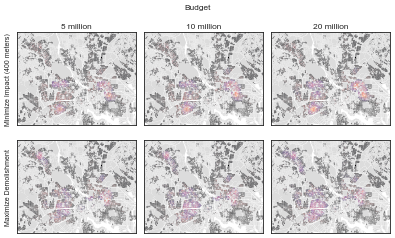

In [114]:
fig ,axes = plt.subplots(nrows = 2,ncols=3,figsize=(8,4.5), dpi=50)#120
Area_plot("model-d400-p0" ,1, 5000000,ax = axes[0][0])
Area_plot("model-d400-p0" ,1, 10000000,ax = axes[0][1])
Area_plot("model-d400-p0" ,1, 20000000,ax = axes[0][2])
Area_plot("base" ,1, 5000000,ax = axes[1][0],radius = 400,power =  0)
Area_plot("base" ,1, 10000000,ax = axes[1][1],radius = 400,power =  0)
Area_plot("base" ,1, 20000000,ax = axes[1][2],radius = 400,power =  0)
for ax in axes[0]:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
for ax in axes[1]:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
fig.suptitle("Budget",y = 1.05)
axes[0][0].set_title("5 million")
axes[0][1].set_title("10 million")
axes[0][2].set_title("20 million")
axes[0][0].set_ylabel("Minimize Impact (400 meters)")
axes[1][0].set_ylabel("Maximize Demolishment")
fig.tight_layout()

In [12]:
#fig.savefig('combineplot/compare_d400_p0_full.pdf',format='pdf', dpi=900,bbox_inches='tight')

analyzing the trade-off between maximizing the demolishment and minimizing the impact to sort of having a better understanding of Baltimomre City and thus providing flexible and reasonable results based on the data.

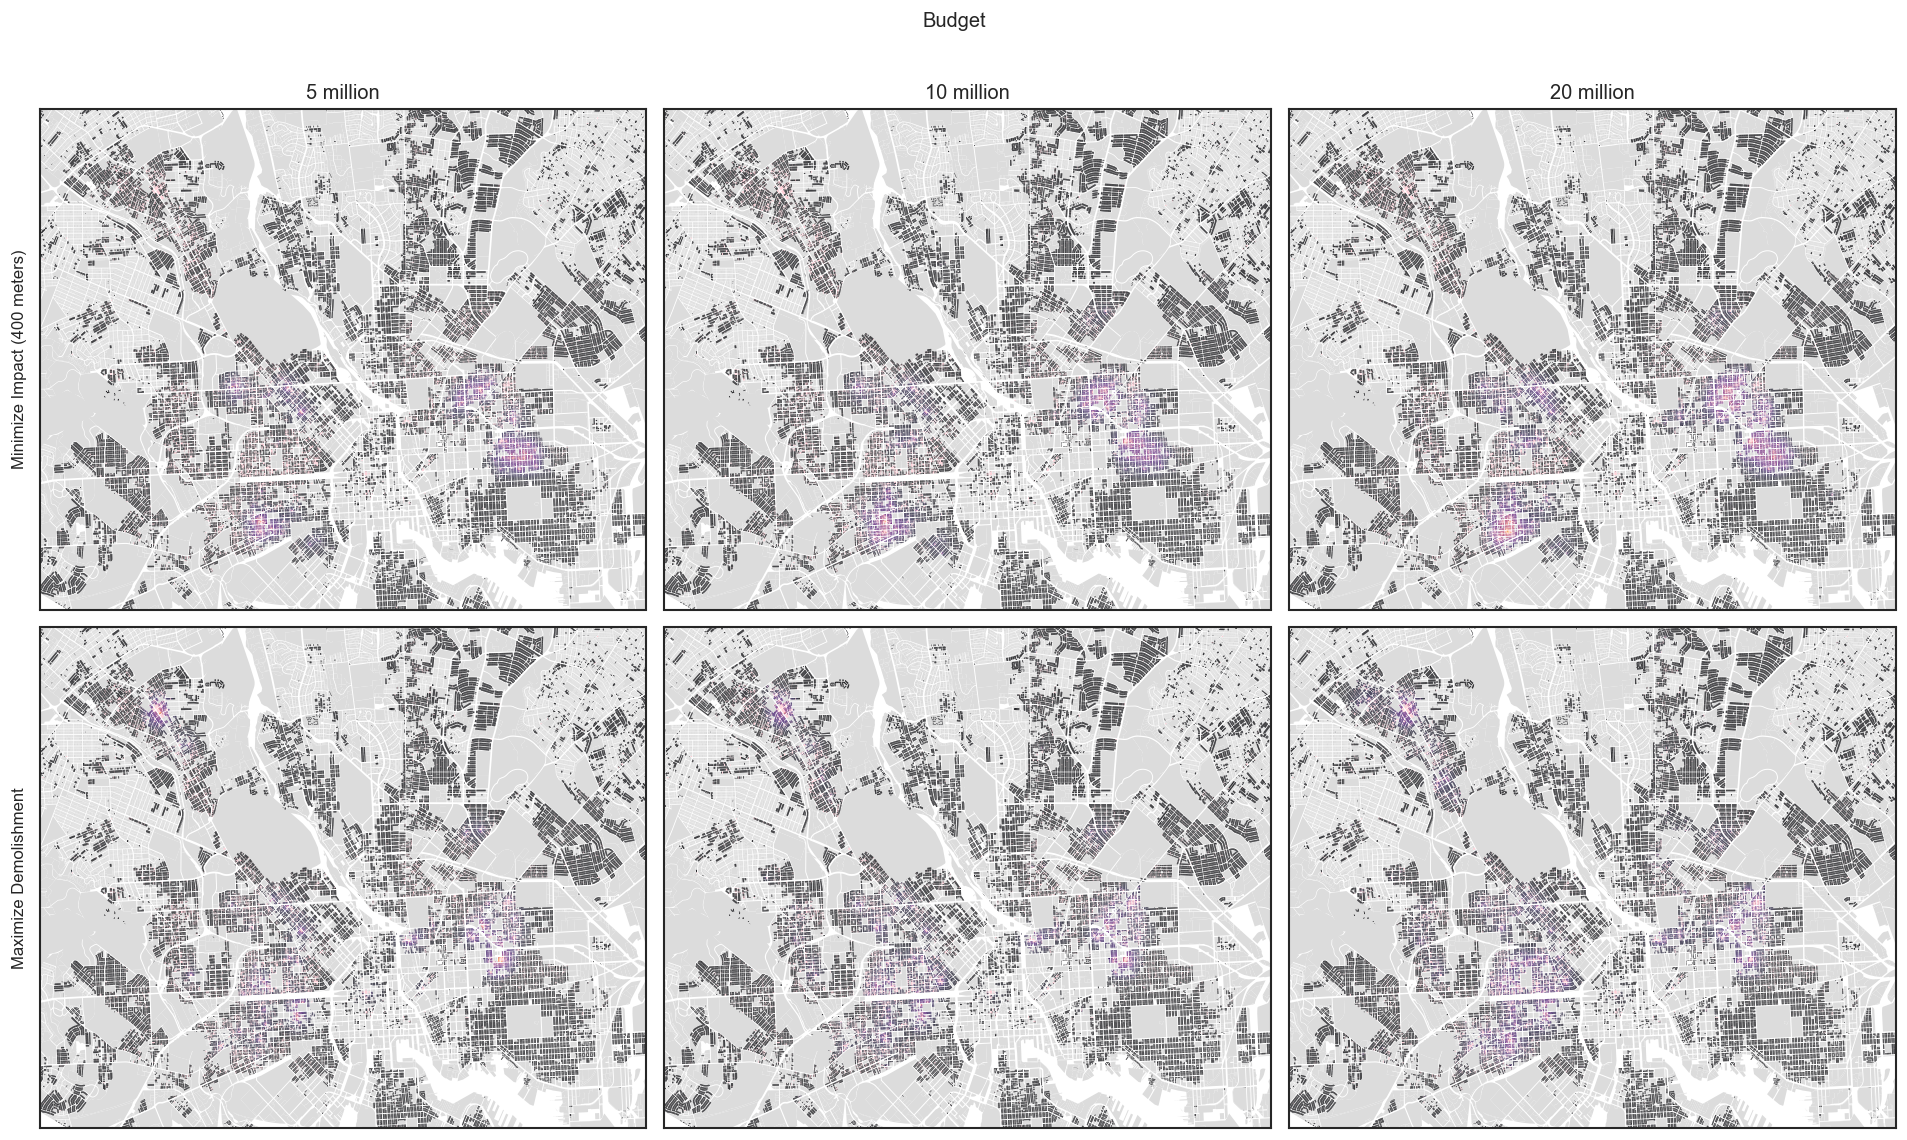

In [99]:
fig ,axes = plt.subplots(nrows = 2,ncols=3,figsize=(16,9), dpi=120)
Area_plot("model-d400-p1" ,1, 5000000,ax = axes[0][0])#,coltype = 2)
Area_plot("model-d400-p1" ,1, 10000000,ax = axes[0][1])#,coltype = 2)
Area_plot("model-d400-p1" ,1, 20000000,ax = axes[0][2])#,coltype = 2)
Area_plot("base" ,1, 5000000,ax = axes[1][0],radius = 400,power =  1)#,coltype = 2)
Area_plot("base" ,1, 10000000,ax = axes[1][1],radius = 400,power =  1)#,coltype = 2)
Area_plot("base" ,1, 20000000,ax = axes[1][2],radius = 400,power =  1)#,coltype = 2)
for ax in axes[0]:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
for ax in axes[1]:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
fig.suptitle("Budget",y = 1.05)
axes[0][0].set_title("5 million")
axes[0][1].set_title("10 million")
axes[0][2].set_title("20 million")
axes[0][0].set_ylabel("Minimize Impact (400 meters)")
axes[1][0].set_ylabel("Maximize Demolishment")
fig.tight_layout();

In [16]:
#fig.savefig('combineplot/compare_d600_p0_3color.pdf',format='pdf', dpi=900,bbox_inches='tight')

In [ ]:
"""
write improvement dictionary
"""
#improvementdict.to_csv('imporvementdictionary')

In [75]:
def plotmodelchart(d,p):
    keys = filter(lambda var: var[1] == d and (var[2] == 0 or var[2] == -1),improvementdict.keys())
    fig, axes = plt.subplots(ncols = 2,figsize=(16,8))
    
    N = len(keys)/2 # N groups
    ind = np.arange(N)  # the x locations for the groups
    width = 0.4       # the width of the bars
    """
    Total Impact Improvement by Budget and Method
    """
    totalimpact = []
    for k in keys:
        totalimpact.append([tuple([k[0]]+[k[2]]),improvementdict[k][1]])
    totalimpact = sorted(totalimpact)
    
    ax = axes[0]
    impact = filter(lambda var: var[0][1] == p,totalimpact) 
    basic = filter(lambda var: var[0][1] == -1, totalimpact)
    
    bar_basic = ax.bar(ind, map(lambda var: var[1], basic), width, color='g')
    bar_impact = ax.bar(ind+ width, map(lambda var: var[1], impact), width, color='b')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Impact')
    ax.set_title('Total Impact Improvement by Budget and Method\n (Radius: {} meters)'.format(d),y=1.03)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('5 million','10 million','20 million'))
    ax.legend((bar_basic[0], bar_impact[0]), ('Maximize Demolishment', 'Minimize Impact'))
    """
    Attach a text label above each bar displaying its height
    """
    for i in xrange(len(bar_impact)):
        height1 = bar_impact[i].get_height()
        height2 = bar_basic[i].get_height()
        ax.text(bar_impact[i].get_x() + bar_impact[i].get_width()/2., 1.01*height1,
                '{} %'.format(round(1.0*(height1 - height2)/height2*100,1)) ,
                ha='center', va='bottom')
        ax.text(bar_basic[i].get_x() + bar_basic[i].get_width()/2., 1.01*height2,
                '%d' % int(height2),
                ha='center', va='bottom')
        
        
    """
    Total Row Houses Covered by Budget and Method
    """
    totalhouses = []
    for k in keys:
        totalhouses.append([tuple([k[0]]+[k[2]]),improvementdict[k][2]])
    totalhouses = sorted(totalhouses)
 
    ax = axes[1]
    impact = filter(lambda var: var[0][1] == p,totalhouses) 
    basic = filter(lambda var: var[0][1] == -1, totalhouses)
    
    bar_basic = ax.bar(ind, map(lambda var: var[1], basic), width, color='g')
    bar_impact = ax.bar(ind+ width, map(lambda var: var[1], impact), width, color='b')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Number of row Houses')
    ax.set_title('Total Row Houses Covered by Budget and Method \n (Radius: {} meters)'.format(d),y=1.03)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('5 million','10 million','20 million'))
    
    ax.legend((bar_basic[0], bar_impact[0]), ('Maximize Demolishment', 'Minimize Impact'))
    
    
    """
    Attach a text label above each bar displaying its height
    """
    for i in xrange(len(bar_impact)):
        height1 = bar_impact[i].get_height()
        height2 = bar_basic[i].get_height()
        ax.text(bar_impact[i].get_x() + bar_impact[i].get_width()/2., 1.01*height1,
                '{} %'.format(round(1.0*(height1 - height2)/height2*100,1)) ,
                ha='center', va='bottom')
        ax.text(bar_basic[i].get_x() + bar_basic[i].get_width()/2., 1.01*height2,
                '%d' % int(height2),
                ha='center', va='bottom')
        
    #fig.savefig('combineplot/impactbarplot_d{}_p{}.png'.format(d,p),format='png', dpi=300,bbox_inches='tight')

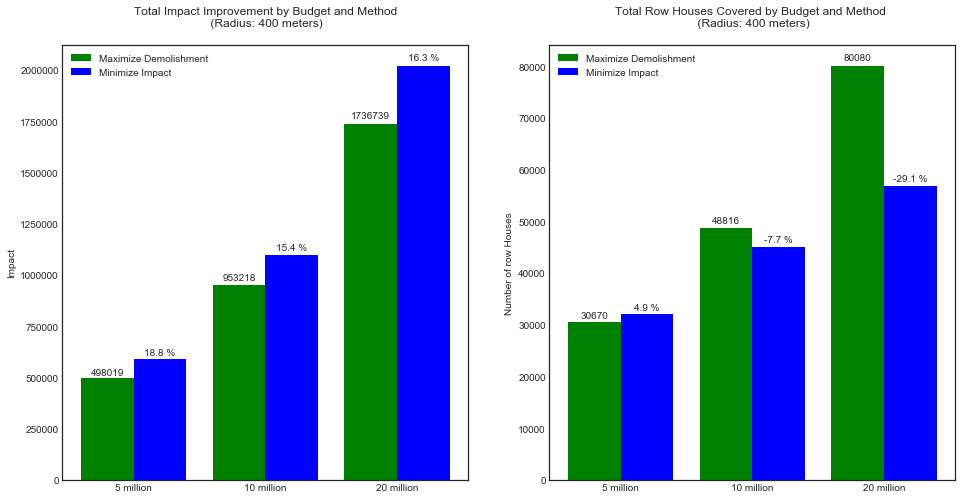

In [193]:
plotmodelchart(400,0)

In [21]:
def plotTotalHouses(d,p):
    impact = model_house_df[(model_house_df.power == p) & 
                   (model_house_df.distance == d) & 
                   (model_house_df.iter == 1) & 
                   (model_house_df.budg <= 20000000)][["Num_of_houses","Cost"]]
    
    basic = model_house_df[(model_house_df.power == -1) & 
                   (model_house_df.distance == -1) & 
                   (model_house_df.iter == 1) & 
                   (model_house_df.budg <= 20000000)][["Num_of_houses","Cost"]]
    
    N = len(impact) # N groups
    ind = np.arange(N)  # the x locations for the groups
    width = 0.4       # the width of the bars
    
    fig, ax = plt.subplots(figsize = (8,8))
    
    """
    Total Impact Improvement by Budget and Method
    """
    himpact = impact.iloc[:,0]
    hbasic = basic.iloc[:,0]
    
    bar_basic = ax.bar(ind, list(hbasic), width, color='g')
    bar_impact = ax.bar(ind+ width,list(himpact), width, color='b')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Number of Total Row Houses')
    ax.set_title('Total Demolishment by Budget and Method \n (radius: {} meters)'.format(d),y=1.03)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('5 million','10 million','20 million'))
    ax.legend((bar_basic[0], bar_impact[0]), ('Maximize Demolishment', 'Minimize Impact'),loc = 2)
    """
    Attach a text label above each bar displaying its height
    """
    for i in xrange(len(bar_impact)):
        height1 = bar_impact[i].get_height()
        height2 = bar_basic[i].get_height()
        ax.text(bar_impact[i].get_x() + bar_impact[i].get_width()/2., 1.01*height1,
                '{} %'.format(round(1.0*(height1 - height2)/height2*100,1)) ,
                ha='center', va='bottom')
        ax.text(bar_impact[i].get_x() + bar_impact[i].get_width()/2., height1+70,
                '$ {}'.format(int(impact.iloc[i,1])) ,
                ha='center', va='bottom')
        
        ax.text(bar_basic[i].get_x() + bar_basic[i].get_width()/2., 1.01*height2,
                '%d' % int(height2),
                ha='center', va='bottom')
        ax.text(bar_basic[i].get_x() + bar_basic[i].get_width()/2., height2+70,
                '$ {}'.format(int(basic.iloc[i,1])),
                ha='center', va='bottom')
    ax.set_ylim(0,1900)
        
    fig.savefig('combineplot/totalbarplot_d{}_p{}.png'.format(d,p),format='png', dpi=300,bbox_inches='tight')

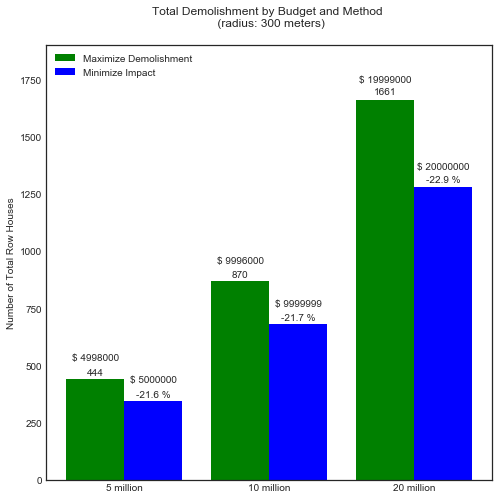

In [195]:
plotTotalHouses(300,0)

In [65]:
def plotTotalHousesFixedBudget(budg,p):
    impact = model_house_df[(model_house_df.power == p) & ( 
                            (model_house_df.distance == 100) |
                            (model_house_df.distance == 200) | 
                            (model_house_df.distance == 300) | 
                            (model_house_df.distance == 400) | 
                            (model_house_df.distance == 500) | 
                            (model_house_df.distance == 600) )& 
                   (model_house_df.iter == 1) & 
                   (model_house_df.budg == budg)][["Num_of_houses","Cost","distance"]]
    impact = impact.sort_values(by = "distance")
    basic = model_house_df[(model_house_df.power == -1) & 
                   (model_house_df.distance == -1) & 
                   (model_house_df.iter == 1) & 
                   (model_house_df.budg == budg)][["Num_of_houses","Cost"]]
    
    N = len(impact) # N groups
    ind = np.arange(N)  # the x locations for the groups
    width = 0.7       # the width of the bars
    
    fig, ax = plt.subplots(figsize = (6,8))
    
    """
    Total Impact Improvement by Budget and Method
    """
    himpact = impact.iloc[:,0]
    hbasic = basic.iloc[:,0]
    
    bar_basic = ax.bar([0], list(hbasic), width, color='g')
    bar_impact = ax.bar(ind+ width,list(himpact), width, color='b')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Number of Total Row Houses')
    #ax.set_title('Total Demolishment by Budget and Method \n (radius: {} meters)'.format(d),y=1.03)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels( impact.iloc[:,2] )
    ax.legend((bar_basic[0], bar_impact[0]), ('Maximize Demolishment', 'Minimize Impact'),loc = 2)
    """
    Attach a text label above each bar displaying its height
    """
    for i in xrange(len(bar_impact)):
        height1 = bar_impact[i].get_height()
        height2 = bar_basic[0].get_height()
        ax.text(bar_impact[i].get_x() + bar_impact[i].get_width()/2., 1.01*height1,
                '{} %'.format(round(1.0*(height1 - height2)/height2*100,1)) ,
                ha='center', va='bottom')
        
    ax.text(bar_basic[0].get_x() + bar_basic[0].get_width()/2., 1.01*height2,
            '%d' % int(height2),
            ha='center', va='bottom')
        
    ax.set_ylim(0,1.5*max(hbasic))
        
    #fig.savefig('combineplot/totalbarplot_d{}_p{}.png'.format(d,p),format='png', dpi=300,bbox_inches='tight')

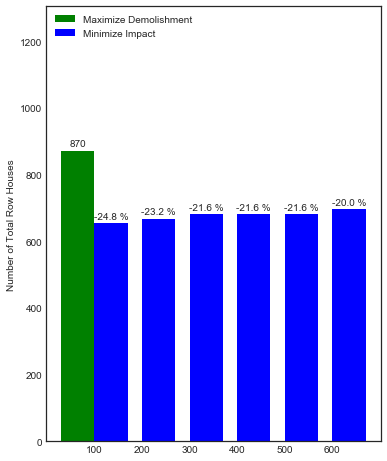

In [128]:
plotTotalHousesFixedBudget(10000000,0)

In [76]:
def plotmodelchartFixedBudget(budg,p):
    keys = filter(lambda var: var[0] == budg ,improvementdict.keys())
    fig, axes = plt.subplots(ncols = 2,figsize=(16,8))
    
    N = len(keys)/2 # N groups
    ind = np.arange(N)  # the x locations for the groups
    width = 0.4       # the width of the bars
    """
    Total Impact Improvement by Budget and Method
    """
    totalimpact = []
    for k in keys:
        totalimpact.append([tuple([k[1]]+[k[2]]),improvementdict[k][1]])
    totalimpact = sorted(totalimpact)
    
    ax = axes[0]
    impact = filter(lambda var: var[0][1] == p,totalimpact) 
    basic = filter(lambda var: var[0][1] == -1, totalimpact)
    
    bar_basic = ax.bar(ind, map(lambda var: var[1], basic), width, color='g')
    bar_impact = ax.bar(ind+ width, map(lambda var: var[1], impact), width, color='b')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Impact')
    ax.set_title('Total Impact Improvement by Budget and Method\n (Radius: {} meters)'.format(d),y=1.03)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(map(lambda var: var[0],impact))
    ax.legend((bar_basic[0], bar_impact[0]), ('Maximize Demolishment', 'Minimize Impact'))
    """
    Attach a text label above each bar displaying its height
    """
    for i in xrange(len(bar_impact)):
        height1 = bar_impact[i].get_height()
        height2 = bar_basic[i].get_height()
        ax.text(bar_impact[i].get_x() + bar_impact[i].get_width()/2., 1.01*height1,
                '{} %'.format(round(1.0*(height1 - height2)/height2*100,1)) ,
                ha='center', va='bottom')
        ax.text(bar_basic[i].get_x() + bar_basic[i].get_width()/2., 1.01*height2,
                '%d' % int(height2),
                ha='center', va='bottom')
        
        
    """
    Total Row Houses Covered by Budget and Method
    """
    totalhouses = []
    for k in keys:
        totalhouses.append([tuple([k[1]]+[k[2]]),improvementdict[k][2]])
    totalhouses = sorted(totalhouses)
 
    ax = axes[1]
    impact = filter(lambda var: var[0][1] == p,totalhouses) 
    basic = filter(lambda var: var[0][1] == -1, totalhouses)
    
    bar_basic = ax.bar(ind, map(lambda var: var[1], basic), width, color='g')
    bar_impact = ax.bar(ind+ width, map(lambda var: var[1], impact), width, color='b')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Number of row Houses')
    ax.set_title('Total Row Houses Covered by Budget and Method \n (Radius: {} meters)'.format(d),y=1.03)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(map(lambda var: var[0],impact))
    
    ax.legend((bar_basic[0], bar_impact[0]), ('Maximize Demolishment', 'Minimize Impact'))
    
    
    """
    Attach a text label above each bar displaying its height
    """
    for i in xrange(len(bar_impact)):
        height1 = bar_impact[i].get_height()
        height2 = bar_basic[i].get_height()
        ax.text(bar_impact[i].get_x() + bar_impact[i].get_width()/2., 1.01*height1,
                '{} %'.format(round(1.0*(height1 - height2)/height2*100,1)) ,
                ha='center', va='bottom')
        ax.text(bar_basic[i].get_x() + bar_basic[i].get_width()/2., 1.01*height2,
                '%d' % int(height2),
                ha='center', va='bottom')
        
    #fig.savefig('combineplot/impactbarplot_d{}_p{}.png'.format(d,p),format='png', dpi=300,bbox_inches='tight')

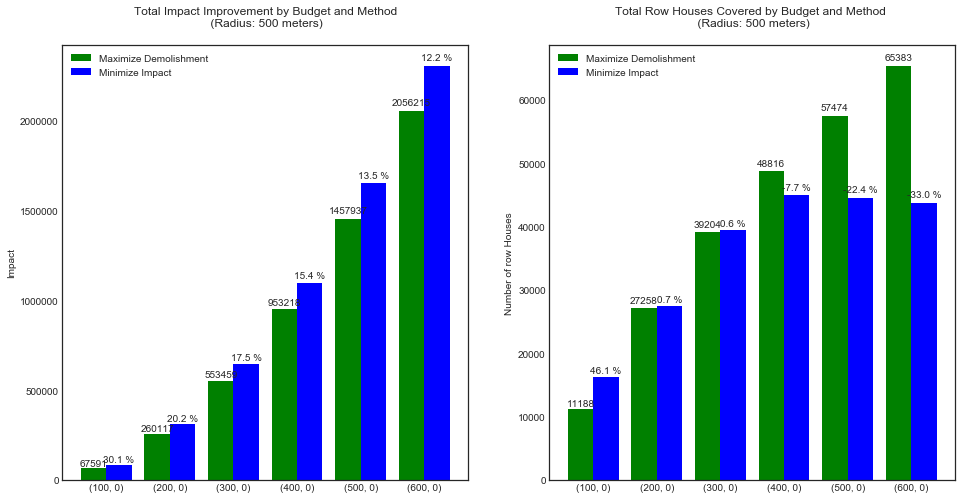

In [129]:
plotmodelchartFixedBudget(10000000,0)

In [185]:
def differFixedDis(d,p):
    keys = filter(lambda var: var[1] == d and (var[2] == 0 or var[2] == -1),improvementdict.keys())
    fig, ax = plt.subplots(figsize=(4,6))
    
    N = len(keys)/2 # N groups
    ind = np.arange(N)  # the x locations for the groups
    width = 0.4       # the width of the bars
    """
    Total Impact Improvement by Budget and Method
    """
    totalimpact = []
    for k in keys:
        totalimpact.append([tuple([k[0]]+[k[2]]),improvementdict[k][1]])
    totalimpact = sorted(totalimpact)
    
    
    impact = np.array(filter(lambda var: var[0][1] == p,totalimpact))
    basic = np.array(filter(lambda var: var[0][1] == -1, totalimpact))
    
    
    
    impactd = model_house_df[(model_house_df.power == p) & 
                   (model_house_df.distance == d) & 
                   (model_house_df.iter == 1) & 
                   (model_house_df.budg <= 20000000)][["Num_of_houses","Cost"]]
    
    basicd = model_house_df[(model_house_df.power == -1) & 
                   (model_house_df.distance == -1) & 
                   (model_house_df.iter == 1) & 
                   (model_house_df.budg <= 20000000)][["Num_of_houses","Cost"]]
    
    
   
    himpact = np.array(impactd.iloc[:,0])
    hbasic = np.array(basicd.iloc[:,0])
    

    ax.bar(range(3),(impact[:,1] - basic[:,1])/basic[:,1]*100  + 1.0*(himpact-hbasic)/hbasic* 100)
    
    
    # add some text for labels, title and axes ticks
    #ax.set_ylabel('Impact')
    #ax.set_title('Total Impact Improvement by Budget and Method\n (Radius: {} meters)'.format(d),y=1.03)
    #ax.set_xticks(ind + width / 2)
    #ax.set_xticklabels(('5 million','10 million','20 million'))
    #ax.legend((bar_basic[0], bar_impact[0]), ('Maximize Demolishment', 'Minimize Impact'))
    """
    Attach a text label above each bar displaying its height
    """
   

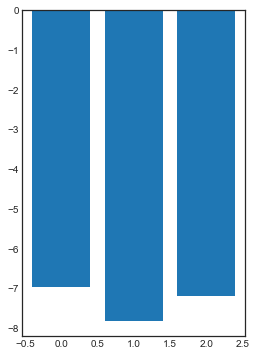

In [198]:
differFixedDis(600,0)

no houses around!


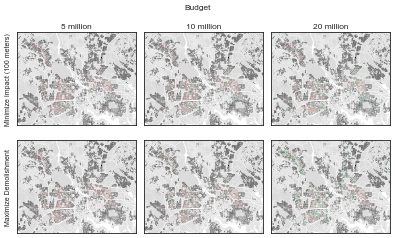

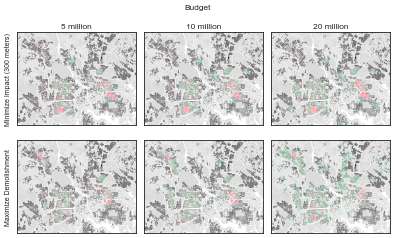

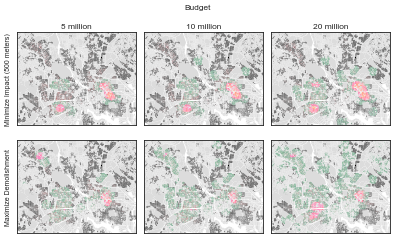

In [33]:
for d in [100,300,500]:

    fig ,axes = plt.subplots(nrows = 2,ncols=3,figsize=(8,4.5), dpi=50)#120
    Area_plot("model-d{}-p0".format(d) ,1, 5000000,ax = axes[0][0],coltype = 2)
    Area_plot("model-d{}-p0".format(d) ,1, 10000000,ax = axes[0][1],coltype = 2)
    Area_plot("model-d{}-p0".format(d) ,1, 20000000,ax = axes[0][2],coltype = 2)
    Area_plot("base" ,1, 5000000,ax = axes[1][0],radius = d,power =  0,coltype = 2)
    Area_plot("base" ,1, 10000000,ax = axes[1][1],radius = d,power =  0,coltype = 2)
    Area_plot("base" ,1, 20000000,ax = axes[1][2],radius = d,power =  0,coltype = 2)
    
    for ax in axes[0]:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    for ax in axes[1]:
        ax.set_yticklabels([])
        ax.set_xticklabels([])

    fig.suptitle("Budget",y = 1.05)
    axes[0][0].set_title("5 million")
    axes[0][1].set_title("10 million")
    axes[0][2].set_title("20 million")
    axes[0][0].set_ylabel("Minimize Impact ({} meters)".format(d))
    axes[1][0].set_ylabel("Maximize Demolishment")
    fig.tight_layout();